![header](../figures/logos_partenaires._cmems_se.jpg)

# Benchmark NeurOST_SSH-SST sea surface height maps

<div style="text-align: right"><i> 2024-09-11 NeurOST_SSH-SST_BENCHMARK_DEMO </i></div>

***
**Authors:**  CLS & Datlas <br>
**Copyright:** 2023 CLS & Datlas <br>
**License:** MIT

<div class="alert alert-block alert-success">
<h1><center>Benchmark of NeurOST_SSH-SST sea surface height maps</center></h1>
<h5> The notebook aims to evaluate the sea surface height maps produced by NeurOST_SSH-SST. </h5>
    <h5> NeurOST (Neural Ocean Surface Topography) is a data-driven SSH mapping method that uses a neural network (architecture = <a href="https://openaccess.thecvf.com/content/CVPR2022/html/Gao_SimVP_Simpler_Yet_Better_Video_Prediction_CVPR_2022_paper.html">SimVP</a>) trained on real-world L3 altimetry observations from 2010-2023 (excluding 2019 for independent validation). There are 2 variants of the method: NeurOST_SSH uses only L3 SLA as input, and NeurOST_SSH-SST which additionally uses the <a href="https://podaac.jpl.nasa.gov/dataset/MUR-JPL-L4-GLOB-v4.1">NASA MUR L4 SST</a> product to improve the mapping of mesoscale eddies. </h5> 
<h5> This method is equivalent to the mapping used to create the <a href="https://doi.org/10.5067/NEURO-STV24">NeurOST NASA PO.DAAC product</a> except that a nadir altimeter (SARAL/Altika, SEALEVEL_GLO_PHY_L3_MY_008_062 product) has been excluded from the mapping.
    </h5>
<h5>Method Citation: </h5>
<ul>
    <li>Martin, S. A., Manucharyan, G. E., and Klein, P. (2024). Deep Learning Improves Global Satellite Observations of Ocean Eddy Dynamics. Geophysical Research Letters, 51, e2024GL110059. https://doi.org/10.1029/2024GL110059</li>
  <li>Martin, S. A., Manucharyan, G. E., and Klein, P. (2023). Synthesizing Sea Surface Temperature and Satellite Altimetry Observations Using Deep Learning Improves the Accuracy and Resolution of Gridded Sea Surface Height Anomalies. Journal of Advances in Modeling Earth Systems, 15, e2022MS003589. https://doi.org/10.1029/2022MS003589</li>
</ul>

<h5> We provide below a demonstration of the validation of these maps against the independent SSH data from the Saral/AltiKa altimeter distributed by CMEMS </h5>
    
<h5>Map data available for download here: UPDATE LINK </h5>
</div>

***
**General Note 1**: Execute each cell through the <button class="btn btn-default btn-xs"><i class="icon-play fa fa-play"></i></button> button from the top MENU (or keyboard shortcut `Shift` + `Enter`).<br>
<br>
**General Note 2**: If, for any reason, the kernel is not working anymore, in the top MENU, click on the <button class="btn btn-default btn-xs"><i class="fa fa-repeat icon-repeat"></i></button> button. Then, in the top MENU, click on "Cell" and select "Run All Above Selected Cell".<br>
***


<div class="alert alert-danger" role="alert">

<h3>Learning outcomes</h3>

At the end of this notebook you will know:
<ul>
  <li>How you can evaluated sea surface height maps with independent alongtrack data: statistical and spectral analysis</li>
</ul>
    
</div>

In [1]:
from glob import glob
import numpy as np
import os

In [2]:
import sys
sys.path.append('..')
from src.mod_plot import *
from src.mod_stat import *
from src.mod_spectral import *
from src.mod_interp import *

/dat1/smart1n/ocean_data_challenges/2023a_SSH_mapping_OSE/nb_diags_global/../src/mod_xscale.py:166: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
  if detrend is 'mean':
/dat1/smart1n/ocean_data_challenges/2023a_SSH_mapping_OSE/nb_diags_global/../src/mod_xscale.py:172: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
  elif detrend is 'linear':


In [3]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

<div class="alert alert-info" role="alert">

<h2>0. Parameters</h2>

</div>

In [5]:
time_min = '2019-01-01'                                        # time min for analysis
time_max = '2019-12-31'                                        # time max for analysis
output_dir = '../results'                                      # output directory path
os.system(f'mkdir -p {output_dir}')
method_name = 'NeurOST_SSH-SST'
stat_output_filename = f'{output_dir}/stat_sla_neurost_ssh-sst.nc'  # output statistical analysis filename
lambda_min = 65.                                               # minimun spatial scale in kilometer to consider on the filtered signal
lambda_max = 500.                                              # maximum spatial scale in kilometer to consider on the filtered signal
psd_output_filename = f'{output_dir}/psd_sla_neurost_ssh-sst.nc'    # output spectral analysis filename
segment_lenght = 1000.                                         # spectral parameer: along-track segment lenght in kilometer to consider in the spectral analysis

<div class="alert alert-info" role="alert">

<h2>1. Input files</h2>

</div>

## Sea Surface Height from Saral/AltiKa

In [6]:
%%time
list_of_file = sorted(glob('../data/independent_alongtrack/alg/2019/*.nc'))
ds_alg = xr.open_mfdataset(list_of_file, combine='nested', concat_dim='time')
ds_alg = ds_alg.where((ds_alg.time >= np.datetime64(time_min)) & (ds_alg.time <=  np.datetime64(time_max)), drop=True)
ds_alg = ds_alg.sortby('time')
ds_alg

CPU times: user 1min 7s, sys: 17.7 s, total: 1min 24s
Wall time: 1min 31s


<xarray.Dataset>
Dimensions:         (time: 14437696)
Coordinates:
  * time            (time) datetime64[ns] 2019-01-01T00:04:07.003014144 ... 2...
    longitude       (time) float64 dask.array<chunksize=(44621,), meta=np.ndarray>
    latitude        (time) float64 dask.array<chunksize=(44621,), meta=np.ndarray>
Data variables:
    cycle           (time) float32 dask.array<chunksize=(44621,), meta=np.ndarray>
    track           (time) float32 dask.array<chunksize=(44621,), meta=np.ndarray>
    sla_unfiltered  (time) float32 dask.array<chunksize=(44621,), meta=np.ndarray>
    sla_filtered    (time) float32 dask.array<chunksize=(44621,), meta=np.ndarray>
    dac             (time) float32 dask.array<chunksize=(44621,), meta=np.ndarray>
    ocean_tide      (time) float32 dask.array<chunksize=(44621,), meta=np.ndarray>
    internal_tide   (time) float32 dask.array<chunksize=(44621,), meta=np.ndarray>
    lwe             (time) float32 dask.array<chunksize=(44621,), meta=np.ndarray>
    mdt             (time) float32 dask.array<chunksize=(44621,), meta=np.ndarray>
    tpa_correction  (time) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea surface height measured by altimeter...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-3 sea su...
    time_coverage_duration:          P24H11M29.716548S
    time_coverage_end:               2019-01-01T23:36:52Z
    time_coverage_resolution:        P1S
    time_coverage_start:             2018-12-31T23:25:22Z
    title:                           DT Altika Drifting Phase Global Ocean Al...

## Sea Level Anomalies maps to evaluate

In [7]:
%%time
list_of_maps = sorted(glob('../data/maps/NeurOST_SSH-SST_allsat-alg/*.nc'))
ds_maps = xr.open_mfdataset(list_of_maps, combine='nested', concat_dim='time')
ds_maps = ds_maps.sel(time=slice(time_min, time_max))
ds_maps

CPU times: user 8.48 s, sys: 142 ms, total: 8.62 s
Wall time: 8.62 s


<xarray.Dataset>
Dimensions:                 (latitude: 1500, longitude: 3600, time: 365)
Coordinates:
  * longitude               (longitude) float64 0.1 0.2 0.3 ... 359.9 360.0
  * latitude                (latitude) float64 -70.0 -69.9 -69.8 ... 79.8 79.9
  * time                    (time) datetime64[ns] 2019-01-01 ... 2019-12-31
    Lambert_Azimuthal_Grid  int32 -2147483647
Data variables:
    sla                     (latitude, longitude, time) float32 dask.array<chunksize=(1500, 3600, 1), meta=np.ndarray>
    adt                     (latitude, longitude, time) float32 dask.array<chunksize=(1500, 3600, 1), meta=np.ndarray>
    ugosa                   (latitude, longitude, time) float32 dask.array<chunksize=(1500, 3600, 1), meta=np.ndarray>
    vgosa                   (latitude, longitude, time) float32 dask.array<chunksize=(1500, 3600, 1), meta=np.ndarray>
    ugos                    (latitude, longitude, time) float32 dask.array<chunksize=(1500, 3600, 1), meta=np.ndarray>
    vgos                    (latitude, longitude, time) float32 dask.array<chunksize=(1500, 3600, 1), meta=np.ndarray>

<div class="alert alert-info" role="alert">

<h2>2. Statistical & Spectral Analysis </h2>

</div>

## 2.1 Interpolate sea surface height maps onto along-track positions

In [8]:
ds_interp = run_interpolation(ds_maps, ds_alg)
ds_interp = ds_interp.dropna('time')
ds_interp

2024-09-11 16:19:59 INFO     fetch data from 2019-01-01 00:00:00 to 2019-02-01 00:00:00
2024-09-11 16:20:04 INFO     fetch data from 2019-01-31 00:00:00 to 2019-03-01 00:00:00
2024-09-11 16:20:07 INFO     fetch data from 2019-02-28 00:00:00 to 2019-04-01 00:00:00
2024-09-11 16:20:11 INFO     fetch data from 2019-03-31 00:00:00 to 2019-05-01 00:00:00
2024-09-11 16:20:15 INFO     fetch data from 2019-04-30 00:00:00 to 2019-06-01 00:00:00
2024-09-11 16:20:19 INFO     fetch data from 2019-05-31 00:00:00 to 2019-07-01 00:00:00
2024-09-11 16:20:23 INFO     fetch data from 2019-06-30 00:00:00 to 2019-08-01 00:00:00
2024-09-11 16:20:26 INFO     fetch data from 2019-07-31 00:00:00 to 2019-09-01 00:00:00
2024-09-11 16:20:30 INFO     fetch data from 2019-08-31 00:00:00 to 2019-10-01 00:00:00
2024-09-11 16:20:34 INFO     fetch data from 2019-09-30 00:00:00 to 2019-11-01 00:00:00
2024-09-11 16:20:38 INFO     fetch data from 2019-10-31 00:00:00 to 2019-12-01 00:00:00
2024-09-11 16:20:42 INFO     fet

<xarray.Dataset>
Dimensions:            (time: 14204985)
Coordinates:
  * time               (time) datetime64[ns] 2019-01-01T00:04:18.619014144 .....
Data variables: (12/13)
    cycle              (time) float32 126.0 126.0 126.0 ... 136.0 136.0 136.0
    track              (time) float32 9.0 9.0 9.0 9.0 ... 408.0 408.0 408.0
    sla_unfiltered     (time) float32 0.074 0.071 0.121 ... 0.007 0.056 0.01
    sla_filtered       (time) float32 0.066 0.066 0.073 ... 0.03 0.031 0.027
    dac                (time) float32 0.343 0.344 0.344 ... 0.172 0.171 0.172
    ocean_tide         (time) float32 -0.104 -0.104 -0.104 ... -0.304 -0.314
    ...                 ...
    lwe                (time) float32 -0.017 -0.016 -0.016 ... 0.014 0.014 0.016
    mdt                (time) float32 -0.134 -0.136 -0.137 ... -1.138 -1.154
    tpa_correction     (time) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    longitude          (time) float64 63.49 63.4 63.31 ... 246.7 246.6 246.3
    latitude           (time) float64 70.51 70.57 70.62 ... -69.27 -69.32 -69.55
    msla_interpolated  (time) float64 0.1274 0.125 0.1233 ... 0.01706 0.02553

## 2.2 Compute grid boxes statistics & statistics by regime (coastal, offshore low variability, offshore high variability)

Once the maps have been interpolated to the position of the along-track, it is possible to calculate different statistics on the time series SLA_alongtrack and SLA_maps. 

We propose below the following statistics: error variance maps (static by 1°x1° box), explained variance maps, temporal evolution of global error variance and explained variance. 

These statistics are also applied to the filtered signals focusing on the 65-500km scale range. A bandpass filter is applied before calculating the scores.  

In [9]:
compute_stat_scores(ds_interp, lambda_min, lambda_max, stat_output_filename,method_name)

2024-09-11 16:20:51 INFO     Compute mapping error all scales
2024-09-11 16:20:51 INFO     Compute mapping error for scales between 65.0 and 500.0 km


Total RMSE= 0.03816042832003461 m
Total RMSE score= 0.706723232979374 m


2024-09-11 16:22:52 INFO     Compute binning statistics
2024-09-11 16:23:20 INFO     Compute statistics by oceanic regime
2024-09-11 16:24:04 INFO     Stat file saved as: ../results/stat_sla_neurost_ssh-sst.nc


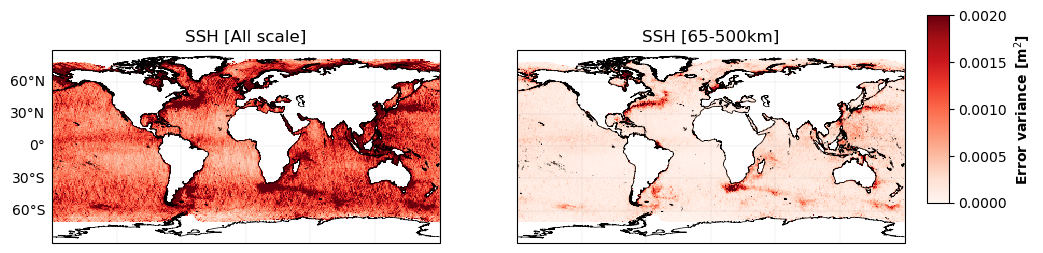

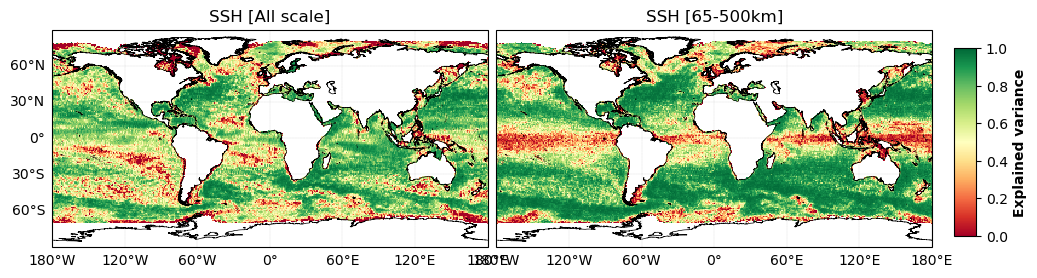

In [10]:
# Plot gridded stats
# Hvplot
# plot_stat_score_map(stat_output_filename)
# Matplotlib
plot_stat_score_map_png(stat_output_filename)

In [13]:
plot_stat_score_timeseries(stat_output_filename)

:Layout
   .Overlay.I  :Overlay
      .Curve.All_scale :Curve   [time]   (timeserie_variance_mapping_err)
      .Curve.Filtered  :Curve   [time]   (timeserie_variance_mapping_err)
   .Overlay.II :Overlay
      .Curve.All_scale :Curve   [time]   (explained_variance_score)
      .Curve.Filtered  :Curve   [time]   (explained_variance_score)

In [11]:
plot_stat_by_regimes(stat_output_filename)

,mapping_err_var [m²],sla_unfiltered_var [m²],mapping_err_filtered_var [m²],sla_filtered_var [m²],var_score_allscale,var_score_filtered
coastal,0.002298,0.008377,0.000495,0.001843,0.725703,0.731345
offshore_highvar,0.002348,0.053256,0.000696,0.021752,0.955914,0.968019
offshore_lowvar,0.001111,0.006310,0.000191,0.001783,0.824014,0.892600
equatorial_band,0.001341,0.005986,0.000297,0.000538,0.775976,0.448401
arctic,0.002138,0.007145,0.000400,0.001070,0.700805,0.626297
antarctic,NaN,NaN,NaN,NaN,NaN,NaN


## 2.3 Compute Spectral scores

In [12]:
compute_psd_scores_v2(ds_interp, psd_output_filename, lenght_scale=segment_lenght,method_name=method_name)

2024-09-11 16:24:18 INFO     Segment computation...
2024-09-11 16:24:29 INFO     Spectral analysis...
2024-09-11 16:33:40 INFO     Saving ouput...
2024-09-11 16:33:48 INFO     PSD file saved as: ../results/psd_sla_neurost_ssh-sst.nc


Averaged effective resolution: 202.41920482665768 km


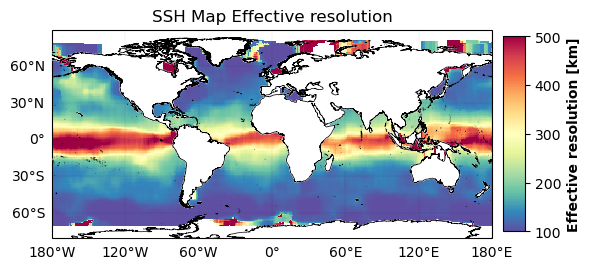

In [13]:
# Plot effective resolution
# Hvplot
# plot_effective_resolution(psd_output_filename)
# Matplotlib
plot_effective_resolution_png(psd_output_filename)

In [17]:
plot_psd_scores(psd_output_filename)

:Layout
   .DynamicMap.I   :DynamicMap   [lon,lat]
      :Overlay
         .Curve.PSD_alongtrack   :Curve   [wavelenght]   (psd_ref)
         .Curve.NOISE_alongtrack :Curve   [wavelenght]   (noise)
         .Curve.PSD_map          :Curve   [wavelenght]   (psd_study)
         .Curve.PSD_err          :Curve   [wavelenght]   (psd_diff)
   .DynamicMap.II  :DynamicMap   [lon,lat]
      :Overlay
         .Curve.PSD_map_over_PSD_ref :Curve   [wavelenght]   (psd_ratio)
         .Curve.I                    :Curve   [wavelenght]   (coherence)
   .DynamicMap.III :DynamicMap   [lon,lat]
      :Overlay
         .Curve.I  :Curve   [wavelenght]   (psd_score)
         .Curve.II :Curve   [wavelenght]   (coherence)
   .DynamicMap.IV  :DynamicMap   [lon,lat]
      :Overlay
         .Curve.I  :Curve   [wavelenght]   (coherence)
         .Curve.II :Curve   [wavelenght]   (coherence)

The interactive plot above allows you to explore the spectral metrics by latitude / longitude box